In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
import pickle

import tifffile as tif

import xarray as xr
import os

from collections import defaultdict
from itertools import islice
import random

from skimage.feature import graycomatrix, graycoprops
from skimage import io, color, img_as_ubyte
from tqdm import tqdm

from sklearn.svm import SVC
from sklearn.model_selection import train_test_split

import math

In [2]:
sar_dir = '/data/exjobb/sarssw/sar_multiprocess/'   
bouy_survey_dir = '../bouy_survey/1h_survey/result_df'
svc_dir = './out/homogenity_svc.pkl'

with open(svc_dir, 'rb') as f: svc = pickle.load(f)
with open(bouy_survey_dir,'rb') as f_r: bouy_survey_df = pickle.load(f_r)
    
bouy_survey_df['sar_name'] = bouy_survey_df['sar_url'].apply(lambda row: row.split('/')[-1].split('.')[0])
bouy_survey_df['bouy_name'] = bouy_survey_df['bouy_file_name'].apply(lambda row: row.split('.')[0])
bouy_survey_df = bouy_survey_df.set_index(['sar_name', 'bouy_name']).sort_index()

/home/sarssw/miniconda3/envs/glcm/lib/python3.11/site-packages/sklearn/base.py:318: UserWarning: Trying to unpickle estimator SVC from version 1.2.1 when using version 1.2.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


In [124]:
# for getting the sigma0
def sar_gen(sar_dir, only_center = False, hom = True):
    sar_files = os.listdir(sar_dir)
    for file_name in sar_files:
        if not file_name.endswith('.tif'): continue
            
        if only_center:
            if not file_name.split('.')[0][-1] == '0': continue
                
        with tif.TiffFile(os.path.join(sar_dir, file_name)) as tif_img:
            #for v in tif_img.asarray():
            v = tif_img.asarray()[0,...]   
            #print(tif_img.shaped_metadata[0])
            if np.isnan(v).any(): continue

            ubyte = img_as_ubyte((v - v.min()) / (v.max() - v.min()))
            glcm = graycomatrix(ubyte, distances=[10], angles=[0], levels=256,
                                symmetric=True, normed=True)

            glcm_types =  ['homogeneity', 'dissimilarity', 'correlation']
            pred = svc.predict([[graycoprops(glcm, gt)[0, 0] for gt in glcm_types]])[0]
            if pred == (0 if hom else 1):
                yield v

In [ ]:
import numpy as np
from itertools import islice

for sigma0 in islice(sar_gen(sar_dir), 100):
    psd = np.abs(np.fft.fft2(sigma0)) ** 2
    psd = psd.mean(axis=1)
    acf = np.fft.ifft(psd)
    acf = np.fft.fftshift(acf)
    #acf = np.abs(acf)
    #acf = (acf - np.min(acf)) / (np.max(acf) - np.min(acf))
    
    #acf = np.convolve(acf, np.ones(7)/7, mode='same')
    
    plt.plot(acf)
    #fwhm = 2 * np.sqrt(2 * np.log(2)) * acf.std()
    fwhm = np.sqrt(2 * np.pi * acf.std())

    # Print the approximated azimuth cutoff wavelength
    print(f"Azimuth cutoff wavelength = {fwhm:.5f}")

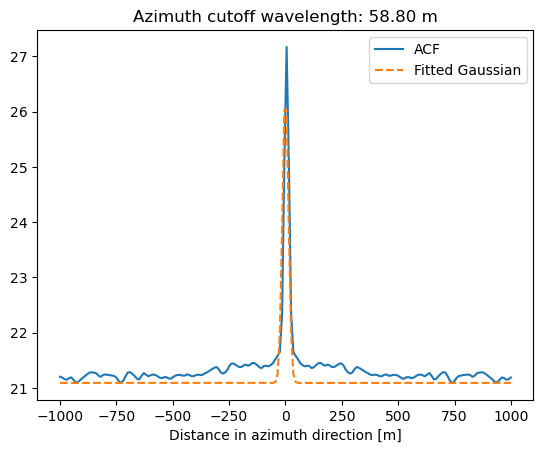

Azimuth cutoff wavelength: 58.80 m


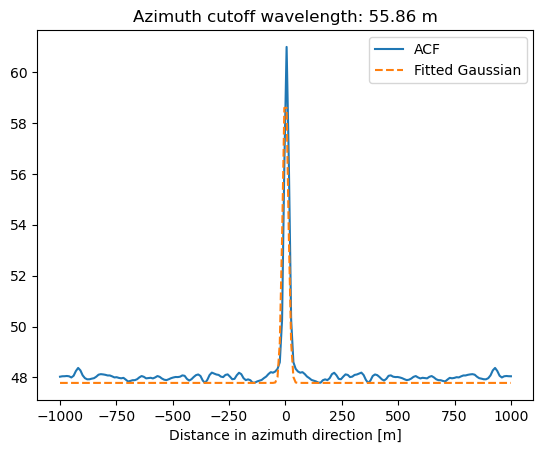

Azimuth cutoff wavelength: 55.86 m


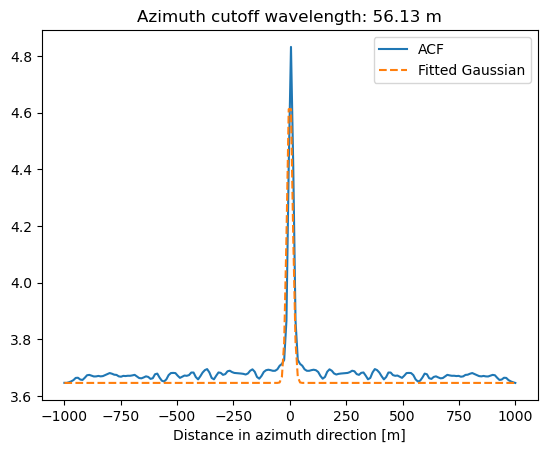

Azimuth cutoff wavelength: 56.13 m


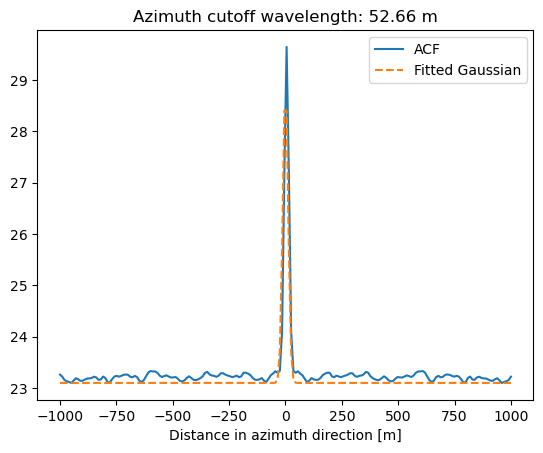

Azimuth cutoff wavelength: 52.66 m


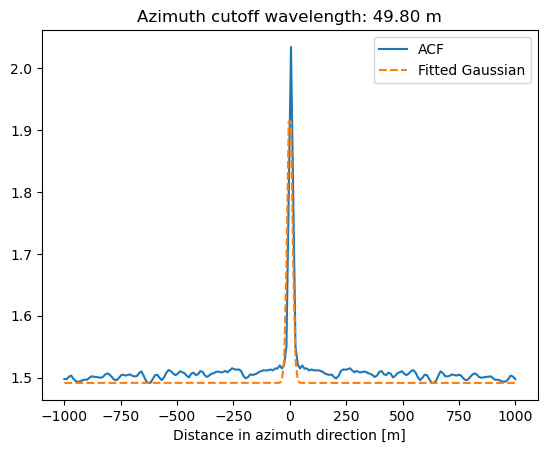

Azimuth cutoff wavelength: 49.80 m


In [166]:
import numpy as np
from itertools import islice
import scipy.signal
import scipy.optimize

def gaussian(x, amplitude, lambda_c):
    return amplitude * np.exp((-(np.pi ** 2)) * ((x ** 2) / (lambda_c ** 2)))

for sigma0 in islice(sar_gen(sar_dir), 5):
    # Calculate acf with wiener_khinchin:
    # the 2-D PSD is evaluated as the square modulus of the Fourier 
    # transform of the VV-polarized uncalibrated intensity image;
    psd = np.abs(np.fft.fft2(sigma0)) ** 2
    # The 1-D azimuth PSD, PSDx, is evaluated by averaging the PSD along the range direction;
    psdx = psd.mean(axis=1)
    # The AACF is obtained by applying the inverse Fourier transform:
    # AACF= 1/n^2 * IFFT(PSDx),
    acf = np.fft.ifft(psdx)
    acf = np.fft.fftshift(acf)
    acf = np.abs(acf)
    
    # A smoothing 7 × 1 median filter is applied to the modulus of the 
    # azimuth autocorrelation function (AACF) in order to remove the 0-lag contribution.
    #acf = scipy.signal.medfilt(acf, kernel_size=7)
    
    # Normalize 
    #acf = (acf - acf.min()) / (acf.max() - acf.min())
    
    # meter conversion for the image, since we have a 2kmx2km subimage that is (200, 200)
    # we want from -1000m to 1000m and 200 samples
    x_data = np.linspace(-1000, 1000, 200)
    # Initial guess for Gaussian parameters
    initial_params = [acf.max() - acf.min(), 200]

    # Fit the Gaussian function
    offset_gaussian = lambda *args: gaussian(*args) + acf.min()
    ps, _ = scipy.optimize.curve_fit(offset_gaussian, x_data, acf, p0=initial_params)
    lambda_c = ps[1]
    
    plt.plot(x_data, acf, label='ACF')
    plt.plot(x_data, offset_gaussian(x_data, *ps), label='Fitted Gaussian', linestyle='--')
    plt.xlabel('Distance in azimuth direction [m]')
    plt.title(f'Azimuth cutoff wavelength: {lambda_c:.2f} m')
    plt.legend()
    plt.show()
    print(f'Azimuth cutoff wavelength: {lambda_c:.2f} m')

In [117]:
# todo change the names so that they dont use a dash as a separator
def unpack_name(name):
    sar_name, *bouy_name, ix = name.split('.')[0].split('-')
    return sar_name, '-'.join(bouy_name), ix

def get_value_old(name, variable_name = 'VHM0'):
    sar_name, bouy_name, _ = unpack_name(name)

    url_df = bouy_survey_df[bouy_survey_df.sar_url.str.contains(sar_name)]
    bouy_df = url_df[url_df.bouy_file_name.str.contains(bouy_name)]
    value = bouy_df[bouy_df.bouy_variable_name == variable_name].bouy_variable_value
    if len(value) == 1: return value.item()

def get_value(sar_name, bouy_name, variable_name = 'VHM0'):
    bouy_df = bouy_survey_df.loc[(sar_name, bouy_name)]
    value = bouy_df[bouy_df.bouy_variable_name == variable_name].bouy_variable_value
    if len(value) == 1: return value.item()

In [115]:
def full_feature_extraction(sar_dir, preliminary_values=False, n_images=None):
    feature_dict = defaultdict(list)
    sar_files = os.listdir(sar_dir)

    for file_name in tqdm(sar_files[:len(sar_files) if n_images is None else n_images]):
        if not file_name.endswith('.tif'): continue
        
        with tif.TiffFile(os.path.join(sar_dir, file_name)) as tif_img:
            metadata_dict, = tif_img.shaped_metadata
            
            if preliminary_values:
                value = get_value(metadata_dict['sar_name'], metadata_dict['bouy_name'])
                
            for v, pol in zip(tif_img.asarray(), metadata_dict['pol']):
                if np.isnan(v).any(): continue

                ubyte = img_as_ubyte((v - v.min()) / (v.max() - v.min()))
                glcm = graycomatrix(ubyte, distances=[10], angles=[0], levels=256,
                                    symmetric=True, normed=True)

                all_glcm_types = ['contrast', 'dissimilarity', 'homogeneity', 'energy', 'correlation', 'ASM']
                sar_glcm = {gt:graycoprops(glcm, gt)[0, 0] for gt in all_glcm_types}

                glcm_types =  ['homogeneity', 'dissimilarity', 'correlation']
                hom_test = svc.predict([[sar_glcm[gt] for gt in glcm_types]])[0] == 0
                
                #filename and polarization for given image
                feature_dict['file_name'].append(file_name)
                feature_dict['pol'].append(pol)
                
                #metadata from image
                for metadata_key, metadata_value in metadata_dict.items():
                    if metadata_key not in ['pol']:
                        feature_dict[metadata_key].append(metadata_value)
                
                #bool for if image is homogenous or not
                feature_dict['hom_test'].append(hom_test)
                
                #all features extracted from glcm
                for glcm_type, glcm_value in sar_glcm.items():
                    feature_dict[glcm_type].append(glcm_value)
                
                #features from sigma0 aggregations
                feature_dict['sigma_mean'].append(v.mean())
                feature_dict['sigma_var'].append(v.var())
                feature_dict['sigma_mean_over_var'].append(v.mean() / v.var())
                feature_dict['sigma_min'].append(v.min())
                feature_dict['sigma_max'].append(v.max())
                feature_dict['sigma_range'].append(v.max() - v.min())
                
                # ACF aproxmiate with Wiegner-Khinchins thm
                # power spectral density
                psd = np.abs(np.fft.fft2(v)) ** 2
                # 2D -> 1D by average over range
                psd = psd.mean(axis=0)
                acf = np.fft.ifft(psd)
                acf = np.fft.fftshift(acf)
                acf = np.real(acf)
                # normalize
                acf = acf / np.max(acf)
                
                # smooth
                acf = np.convolve(acf, np.ones(7)/7, mode='same')
                
                fwhm = 2 * np.sqrt(2 * np.log(2)) * acf.std()
                
                feature_dict['azm_ctf_wvl'].append(fwhm)
                
                if preliminary_values:
                    feature_dict['preliminary_value'].append(value)

    return pd.DataFrame(feature_dict)

In [118]:
feature_df = full_feature_extraction(sar_dir, preliminary_values=True, n_images=10000)
feature_df

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10000/10000 [08:13<00:00, 20.27it/s]


defaultdict(list,
            {'file_name': ['S1B_IW_GRDH_1SDV_20211111T055808_20211111T055833_029536_03866C_DA16-NO_TS_MO_LichteilandGoeree1-7.tif',
              'S1B_IW_GRDH_1SDV_20211111T055808_20211111T055833_029536_03866C_DA16-NO_TS_MO_LichteilandGoeree1-7.tif',
              'S1A_IW_GRDH_1SDV_20211012T055839_20211012T055904_040082_04BEED_8002-NO_TS_MO_WielingenNoord-8.tif',
              'S1A_IW_GRDH_1SDV_20211012T055839_20211012T055904_040082_04BEED_8002-NO_TS_MO_WielingenNoord-8.tif',
              'S1B_IW_GRDH_1SDV_20210208T055759_20210208T055824_025511_030A28_FCBC-NO_TS_MO_Europlatform2-3.tif',
              'S1B_IW_GRDH_1SDV_20210208T055759_20210208T055824_025511_030A28_FCBC-NO_TS_MO_Europlatform2-3.tif',
              'S1A_IW_GRDH_1SDV_20211226T173326_20211226T173351_041183_04E4CB_2659-NO_TS_MO_Schouwenbank-6.tif',
              'S1A_IW_GRDH_1SDV_20211226T173326_20211226T173351_041183_04E4CB_2659-NO_TS_MO_Schouwenbank-6.tif',
              'S1A_IW_GRDH_1SDV_20210711T173324

In [126]:
hom_df = feature_df[feature_df.hom_test]
hom_df[hom_df.pol == 'VV'].corr()

/tmp/ipykernel_476/693299224.py:2: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  hom_df[hom_df.pol == 'VV'].corr()


,offset_index,lon,lat,hom_test,contrast,dissimilarity,homogeneity,energy,correlation,ASM,sigma_mean,sigma_var,sigma_mean_over_var,sigma_min,sigma_max,sigma_range,azm_ctf_wvl,preliminary_value
offset_index,1.000000,-0.015421,-0.014764,NaN,-0.015751,-0.015895,0.008989,-0.016413,-0.004928,-0.017615,0.034639,0.021059,-0.042577,0.020138,0.034897,0.034947,-0.012043,0.003250
lon,-0.015421,1.000000,0.906005,NaN,-0.015732,-0.022511,0.026673,0.030625,0.023665,0.017153,0.103785,0.170358,-0.065347,0.088537,0.145385,0.145549,-0.015211,0.149982
lat,-0.014764,0.906005,1.000000,NaN,-0.006382,-0.013060,0.021800,0.036977,-0.017589,0.023164,0.102096,0.151354,-0.052559,0.118285,0.141532,0.141380,-0.006253,0.264533
hom_test,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
contrast,-0.015751,-0.015732,-0.006382,NaN,1.000000,0.994648,-0.918417,-0.614763,-0.198056,-0.558314,0.012006,-0.028201,0.000034,0.046731,-0.176628,-0.178325,-0.222968,-0.102617
dissimilarity,-0.015895,-0.022511,-0.013060,NaN,0.994648,1.000000,-0.946539,-0.637573,-0.223472,-0.584140,0.009440,-0.035208,0.003545,0.048100,-0.183213,-0.184970,-0.251123,-0.107598
homogeneity,0.008989,0.026673,0.021800,NaN,-0.918417,-0.946539,1.000000,0.778765,0.322746,0.738002,-0.117967,-0.013859,0.137680,-0.119863,0.078760,0.080478,0.441718,0.012944
energy,-0.016413,0.030625,0.036977,NaN,-0.614763,-0.637573,0.778765,1.000000,0.234679,0.982618,-0.351131,-0.155139,0.560365,-0.190317,-0.194264,-0.193784,0.518660,-0.183713
correlation,-0.004928,0.023665,-0.017589,NaN,-0.198056,-0.223472,0.322746,0.234679,1.000000,0.238425,-0.086110,0.007502,0.068090,-0.085806,-0.045601,-0.045089,0.490996,-0.093206
ASM,-0.017615,0.017153,0.023164,NaN,-0.558314,-0.584140,0.738002,0.982618,0.238425,1.000000,-0.329108,-0.145722,0.529136,-0.179695,-0.192695,-0.192308,0.555076,-0.190509
